In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import model
import helpers
import agents

from model import ReductionModel
from helpers import load_vectors, generate_word_vectors, generate_zipfian_sample, load_info, compute_average_vocabulary, compute_mean_communicative_success_per_token

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from umap import UMAP
from tqdm.auto import tqdm

In [4]:
def combine_plots(model, ax1_func, ax2_func, ax3_func, ax4_func, ax5_func, ax6_func):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 12))

    # Call the first plotting function and get the axes
    ax1_func(model, ax=ax1)
    ax1 = plt.gca()  # Get the current axes

    # Call the second plotting function and get the axes
    ax2_func(model, ax=ax2)
    ax2 = plt.gca() # Get the current axes

    # Call the third plotting function and get the axes
    ax3_func(model, ax=ax3)
    ax3 = plt.gca()  # Get the current axes

    # Call the fourth plotting function and get the axes
    ax4_func(model, ax=ax4)
    ax4 = plt.gca()  # Get the current axes

    # Call the fifth plotting function and get the axes
    ax5_func(model, ax=ax5)
    ax5 = plt.gca()  # Get the current axes

    # Call the sixth plotting function and get the axes
    ax6_func(model, ax=ax6)
    ax6 = plt.gca()  # Get the current axes

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [5]:
def words_reduction_plot(model, show_all_words=False, ax=None):
    df = model.datacollector.get_model_vars_dataframe()
    matrix_3d = np.stack(df["words_zero_ratio"].to_numpy())

    if ax is None:
        ax = plt
        plt.ylim([0, 1])
    else:
        ax.set_ylim([0, 1])

    steps = math.floor(len(model.tokens) / 10)

    ax.plot(matrix_3d[::,::steps if not show_all_words else 1])
    chosen_word_indices = range(0, model.num_tokens, steps if not show_all_words else 1)
    legend_values = [ f"{model.tokens[chosen_word_index]} {model.ranks[chosen_word_index]}" for chosen_word_index in chosen_word_indices ]
    ax.legend(legend_values)

In [6]:
def words_reduction_plot_first_n(model, n=10, jitter_strength=0.02, ax=None):
    df = model.datacollector.get_model_vars_dataframe()
    matrix_3d = np.stack(df["words_zero_ratio"].to_numpy())

    if ax is None:
        ax = plt
        plt.ylim([0, 1])
    else:
        ax.set_ylim([0, 1])

    chosen_word_indices = range(0, n)
    legend_values = [ model.tokens[chosen_word_index] for chosen_word_index in chosen_word_indices ]

    # Get frequencies and normalize them
    frequencies = np.array([model.frequencies[i] for i in chosen_word_indices])
    log_freq = np.log1p(frequencies)  # log1p to avoid log(0)
    log_freq = (log_freq - log_freq.min()) / (log_freq.max() - log_freq.min())  # Normalize between 0 and 1

    # Create colors (darker for more frequent)
    colors = [plt.cm.Blues(f) for f in log_freq]

    # Plot each word with its corresponding color
    for i, color in zip(chosen_word_indices, colors):
        jitter = np.random.uniform(-jitter_strength, jitter_strength)
        ax.plot(matrix_3d[:, i] + jitter, color=color, label=f"{model.tokens[i]} {model.ranks[i]}")

    ax.legend(legend_values)

In [7]:
def words_communication_success_first_n(model, n=10, attr="mean_success_per_token", jitter_strength=0.02, ax=None):
    df = model.datacollector.get_model_vars_dataframe()
    matrix_3d = np.stack(df[attr].to_numpy())

    if ax is None:
        ax = plt
        plt.ylim([0, 1])
    else:
        ax.set_ylim([0, 1])

    chosen_word_indices = range(0, n)
    legend_values = [ model.tokens[chosen_word_index] for chosen_word_index in chosen_word_indices ]

    # Get success for each token
    frequencies = np.array([model.frequencies[i] for i in chosen_word_indices])
    log_freq = np.log1p(frequencies)  # log1p to avoid log(0)
    log_freq = (log_freq - log_freq.min()) / (log_freq.max() - log_freq.min())  # Normalize between 0 and 1

    # Create colors (darker for more frequent)
    colors = [plt.cm.Blues(f) for f in log_freq]

    # Plot each word with its corresponding color
    for i, color in zip(chosen_word_indices, colors):
        window_length = 1000
        polyorder = 1
        
        y_smooth_success = savgol_filter(matrix_3d[:, i], window_length, polyorder)
        ax.plot(y_smooth_success, label=f"{model.tokens[i]} {model.ranks[i]}")

    ax.legend(legend_values)

In [8]:
def make_communication_plot(model, smooth=True, ax=None):
    df = model.datacollector.get_model_vars_dataframe()

    if ax is None:
        ax = plt
        plt.ylim([0, 1])
    else:
        ax.set_ylim([0, 1])
    
    if smooth:
        window_length = 1000
        polyorder = 1
        
        y_smooth_success = savgol_filter(df["communicative_success"], window_length, polyorder)
        y_smooth_failure = savgol_filter(df["communicative_failure"], window_length, polyorder)
        
        ax.plot(y_smooth_success, color="green")
        ax.plot(y_smooth_failure, color="red")
    else:
        ax.plot(df["communicative_success"], color="green")
        ax.plot(df["communicative_failure"], color="red")
    
    return ax

In [9]:
def make_repairs_plot(model, smooth=True, ax=None):
    df = model.datacollector.get_model_vars_dataframe()

    if ax is None:
        ax = plt
    
    if smooth:
        window_length = 100
        polyorder = 1
        
        y_smooth_repairs = savgol_filter(df["total_repairs"], window_length, polyorder)
        
        ax.plot(y_smooth_repairs, color="blue")
    else:
        ax.plot(df["total_repairs"], color="green")
    
    return ax

In [10]:
def make_communicative_success_probability_plot(model, smooth=True, ax=None):
    df = model.datacollector.get_model_vars_dataframe()

    if ax is None:
        ax = plt
        plt.ylim([0, 1])
    else:
        ax.set_ylim([0, 1])
    
    if smooth:
        window_length = 1000
        polyorder = 1
        
        y_smooth_success = savgol_filter(df["average_communicative_success_probability"], window_length, polyorder)
        
        ax.plot(y_smooth_success, color="blue")
    else:
        ax.plot(df["average_communicative_success_probability"], color="blue")
    
    return ax

In [11]:
def make_words_distribution_plot(model, ax=None):
    df = model.datacollector.get_model_vars_dataframe()
    
    tokens_chosen = df["tokens_chosen"].iloc[-1]
    tokens = tokens_chosen.keys()
    frequencies = tokens_chosen.values()

    if ax is None:
        ax = plt
    
    ax.tick_params(axis='x', labelrotation=90, labelsize=8)
    ax.bar(tokens, frequencies)
    
    return ax

In [12]:
def make_confusion_plot(model, step, n=35, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))

    df = model.datacollector.get_model_vars_dataframe()
    confusion_matrix = df["confusion_matrix"].iloc[step]

    row_sums = confusion_matrix.sum(axis=1, keepdims=True)
    normalized_confusion_matrix = confusion_matrix / row_sums
    ax.matshow(normalized_confusion_matrix[0:n,0:n])

    labels = model.tokens[0:n]

    ax.set_xticks(range(0, n))
    ax.set_yticks(range(0, n))
    ax.tick_params(axis='x', labelrotation=90)
    
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    return ax

In [13]:
def make_umap_plot(model, step, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))

    df = model.datacollector.get_model_vars_dataframe()
    if step < 0:
        vocabulary = model.vectors
    else:
        vocabulary = df["average_vocabulary"].iloc[step]

    umap_2d = UMAP(n_components=2, init='random', random_state=0)
    proj_2d = umap_2d.fit_transform(np.asarray(vocabulary))
    x,y = zip(*proj_2d)
    ax.scatter(x, y, c=model.percentiles, cmap='gray')

In [14]:
def make_layout_plot(model, plot_function, steps=[100, 1000, 5000, 10000], **kwargs):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

    plot_function(model, step=steps[0] - 1, ax=ax1, **kwargs)
    plot_function(model, step=steps[1] - 1, ax=ax2, **kwargs)
    plot_function(model, step=steps[2] - 1, ax=ax3, **kwargs)
    plot_function(model, step=model.steps - 1, ax=ax4, **kwargs)

In [4]:
NUM_AGENTS = 25
NUM_DIMENSIONS = 50
NUM_TOKENS = 100
# vectors, tokens, frequencies, percentiles = load_vectors(f"materials/vectors-{NUM_DIMENSIONS}.txt")
tokens, frequencies, percentiles, ranks = load_info(f"theoretical-percentile-info-{NUM_TOKENS}.tsv", theoretical=True)
# Overwrite vectors with my own
vectors = generate_word_vectors(vocabulary_size=len(tokens), dimensions=NUM_DIMENSIONS)

In [ ]:
STEPS_COUNT = 1000
model = ReductionModel(NUM_AGENTS, vectors, tokens, frequencies, percentiles, ranks,
                       reduction_prior=1)
# model.agents[0].indices_in_memory
model.step()
# for _ in tqdm(range(STEPS_COUNT), total=STEPS_COUNT):
#     model.step()

Lower dimension limit is 5


  0%|          | 0/1000 [00:00<?, ?it/s]

RuntimeError: Lambda reporter 'words_zero_ratio' failed validation: 'ReductionAgent' object has no attribute 'vocabulary'
Example: lambda m: len(m.agents)

In [ ]:
all_sampled_indices = []

for agent in model.agents:
    unique_indices = agent.indices_in_memory[~np.isnan(agent.indices_in_memory)]
    unique_indices = unique_indices.astype(int)
    unique_indices = set(unique_indices)

    all_sampled_indices += list(unique_indices)

set(all_sampled_indices)

In [ ]:
model.agents[0].indices_in_memory

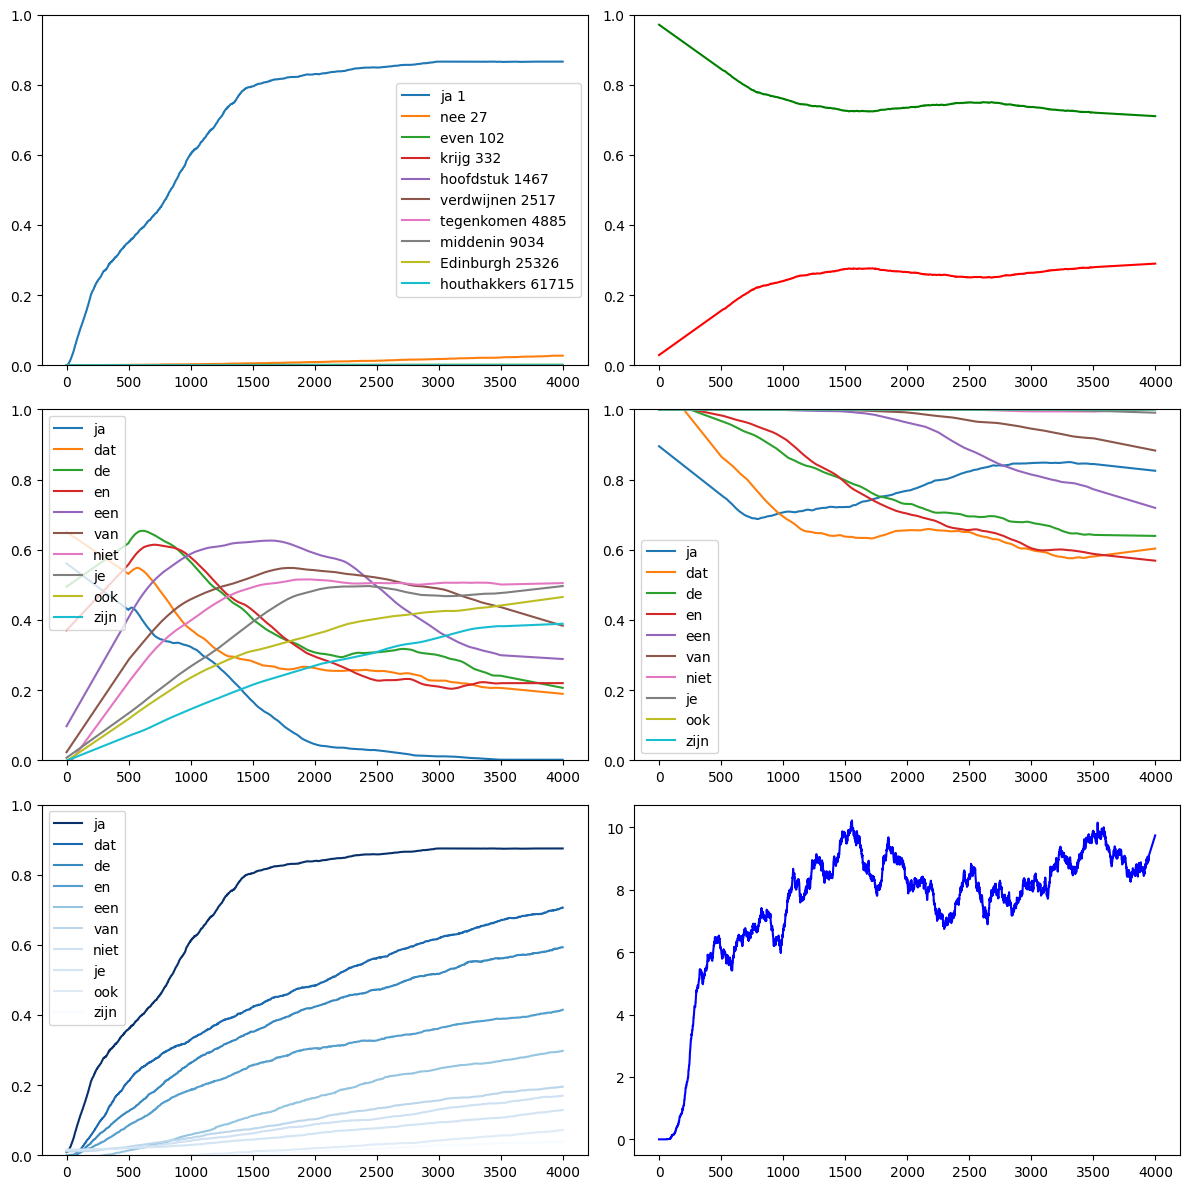

In [48]:
combine_plots(model, words_reduction_plot,
              make_communication_plot,
              lambda model, ax: words_communication_success_first_n(model, ax=ax, attr="mean_reduction_per_token"),
              words_communication_success_first_n,
              words_reduction_plot_first_n,
              make_repairs_plot)

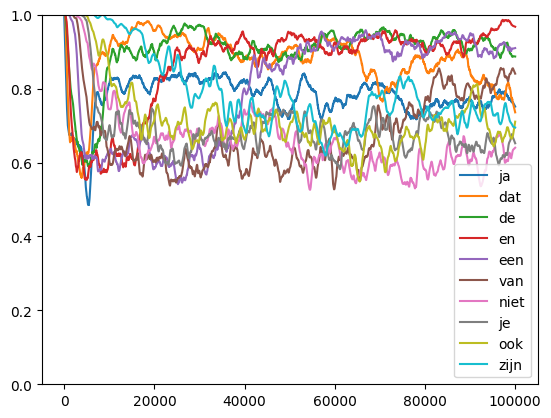

In [197]:
words_communication_success_first_n(model)

/tmp/ipykernel_4036601/1888497126.py:9: RuntimeWarning: invalid value encountered in divide
  normalized_confusion_matrix = confusion_matrix / row_sums
/tmp/ipykernel_4036601/1888497126.py:9: RuntimeWarning: invalid value encountered in divide
  normalized_confusion_matrix = confusion_matrix / row_sums
/tmp/ipykernel_4036601/1888497126.py:9: RuntimeWarning: invalid value encountered in divide
  normalized_confusion_matrix = confusion_matrix / row_sums


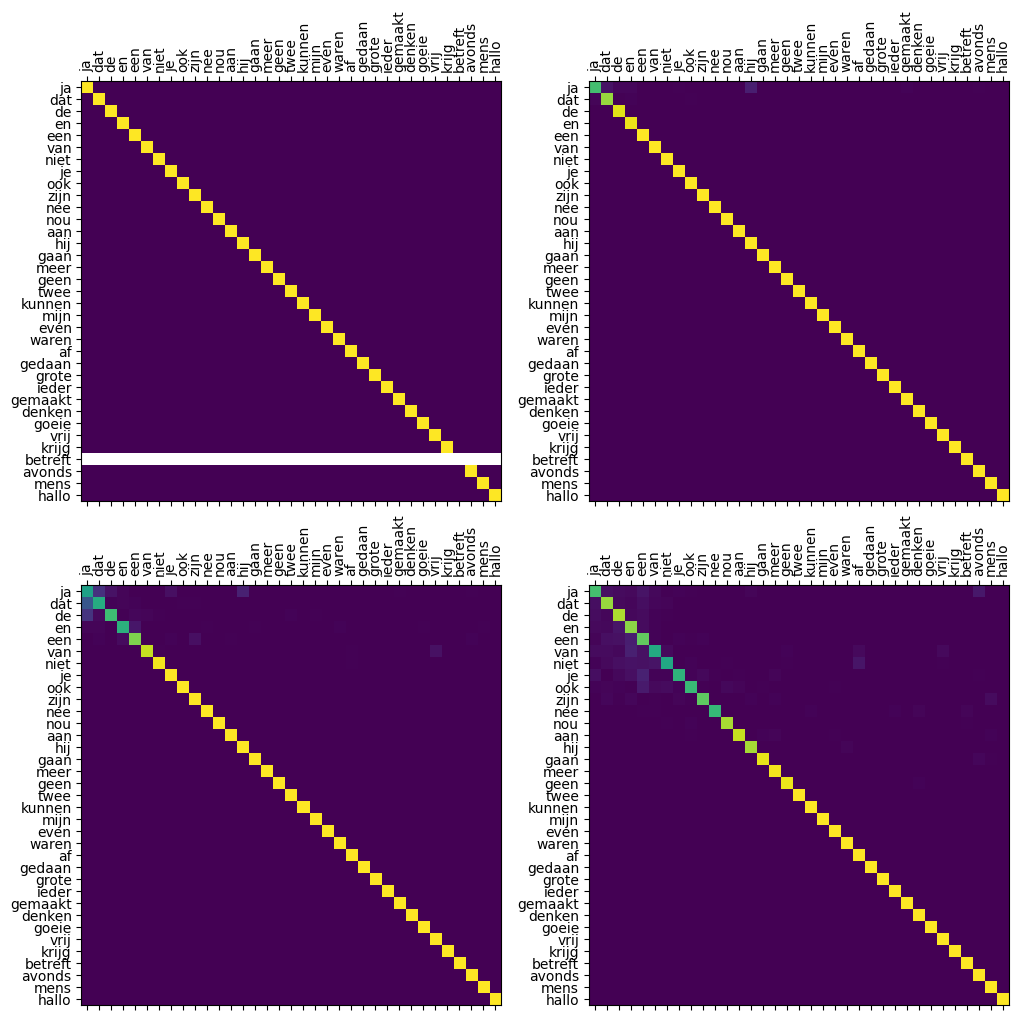

In [198]:
make_layout_plot(model, make_confusion_plot, n=35)

/home/local/anthe/Projects/fwo-frequency-reduction/venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/local/anthe/Projects/fwo-frequency-reduction/venv/lib64/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/local/anthe/Projects/fwo-frequency-reduction/venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/local/anthe/Projects/fwo-frequency-reduction/venv/lib64/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/local/anthe/Projects/fwo-frequency-reduction/venv/lib64/python3.11/site-packages/skl

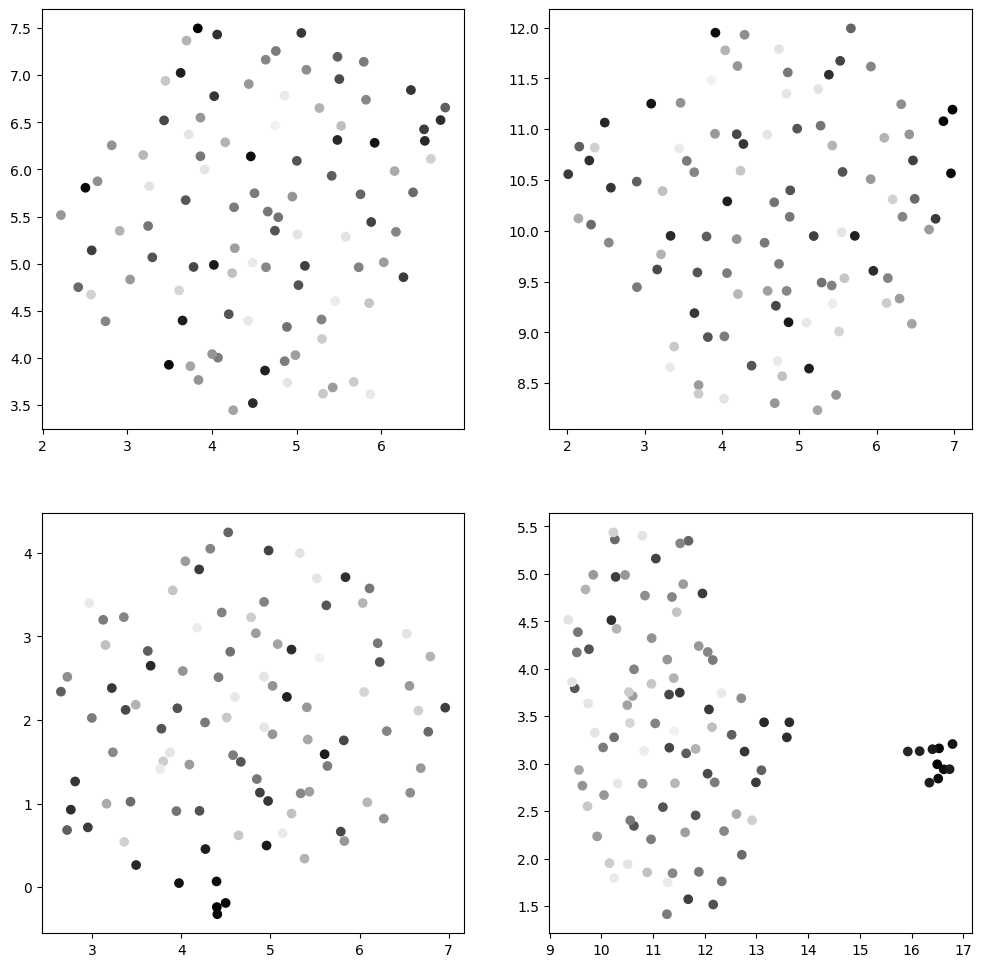

In [199]:
make_layout_plot(model, make_umap_plot,steps=[-1, 1000, 5000, model.steps])

In [1]:
import numpy as np

# Example vocabulary matrix with shape (token_count, dimension_count)
vocabulary_matrix = np.array([[1, 2, 3, 4, 5], [2, 8, 9, 6, 5], [9, 6, 3, 8, 7]])
print(vocabulary_matrix.shape)

# Number of copies you want for each token
num_copies = 5

# Add a new axis and repeat each token (row) 20 times
expanded_vocabulary_matrix = np.tile(vocabulary_matrix[:, np.newaxis, :], (1, num_copies, 1))

token_index = 0
exemplar_index = 5
#expanded_vocabulary_matrix[token_index, exemplar_index, :]

expanded_vocabulary_matrix[token_index, :-1, :] = expanded_vocabulary_matrix[token_index, 1:, :]
expanded_vocabulary_matrix[token_index, -1, :] = [5, 0, 5, 0, 5]
single_agent_r = (expanded_vocabulary_matrix == 0).sum(axis=2).sum(axis=1) / (num_copies * 5)
# Faux copy it a few more times
#np.tile(single_agent_r, (5, 1)).mean(axis=0)

np.zeros(single_agent_r)

(3, 5)


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [119]:
proportion_successful = 1
reduction_count = 1
epsilon = 0.001
u = math.sqrt((proportion_successful * (1 - proportion_successful)) + epsilon / ((reduction_count) + epsilon))
print(u)
k = 4
theta = 0.5
lamb = 3
p_reduce = (1 / (1 + np.exp(-k * (proportion_successful - theta - lamb * u))))
p_reduce

0.0316069770620507


0.8348938892334717